# Conditional GAN

**Author** Luis Leal.

Original paper: [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)


This notebook is based on chapter 8 of "gans in action" https://vladimirbok.com/

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                         Embedding, Flatten, Input, Multiply, Reshape, LeakyReLU, Conv2D, Conv2DTranspose
                         )
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [3]:
img_rows = 28
img_cols = 28
img_channels = 1

img_shape = (img_rows, img_cols, img_channels)

#size of the input noise vector for the generator
z_dim = 100

# total number of classes in the dataset(digits)
num_classes = 10

## Generator

In [4]:
def build_generator(z_dim):
    model = Sequential()
    
    # reshape input starting from small "image" 7x7x256
    model.add(Dense(256 * 7 * 7, input_dim = z_dim))
    model.add(Reshape((7,7,256)))
    
    # transpose convolution for upsampling 14x14x128
    model.add(Conv2DTranspose(256, kernel_size=3, strides=2, padding="same"))
    
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    # transpose conv for upsampling to 28x28x1(the target value)
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding="same"))
    
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    #transpose conv reshaping from 28x28x1 to 28x28x1
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding="same"))
    
    # output layer should output values between [-1,1]
    model.add(Activation("tanh"))
    
    return model

In [5]:
def build_cgan_generator(z_dim):
    """
    An embedding tensor will be learned to create representations for every digit
    this embedding will be reshaped to match the size of the noise input vector
    these will be then multiplied elmentwise
    this will be the input to the encoder, containing both random noise and digit representation
    Note: maybe it's better to just concat the noise vector to a one-hot encoding of the digits?
    I feel since we multiply by a random vector the model will have hard time to distinguish digit labels
    """
    # random noise vector
    z = Input(shape=(z_dim,))
    
    # scalar from 0 to 9 specifying what digit to generate
    label = Input(shape=(1,),dtype="int32")
    
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label) #batch_size x 1 x z_dim
    
    flat_label_embedding = Flatten()(label_embedding) #batch_size x z_dim
    
    joined_representation = Multiply()([z, flat_label_embedding]) #batch_size x z_dim
    
    generator = build_generator(z_dim)
    
    conditioned_img = generator(joined_representation)
    
    return Model([z,label],conditioned_img)
    

## Discriminator


In [6]:
def build_discriminator(img_shape):
    
    # the input "image" will have 2 channels, the image itself
    # and the second channel is the label(for conditioning) replicated
    # input shape: 28x28x2
    
    model = Sequential()
    
    # from 28x28x2 to 14x14x64
    model.add(Conv2D(
        64,
        kernel_size=3,
        strides=2,
        input_shape = (img_shape[0],img_shape[1],img_shape[2] + 1),
        padding="same"
    ))
    
    model.add(LeakyReLU(alpha=0.01))
    
    # from 14x14x64 to 7x7x64
    model.add(
        Conv2D(64,
              kernel_size=3,
               strides=2,
               input_shape = img_shape,
               padding="same"
              )
    )
    
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    # from 7x7x64 to 3x3x128
    model.add(
        Conv2D(128,
              kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding="same"
              )
    )
    
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    # discriminator as classifier (before wgan era)
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    
    return model
    

In [7]:
def buil_cgan_discriminator(img_shape):
    """
    An embedding tensor will be learned to create representations for every digit
    this embedding will be reshaped to match the size of the input images
    then the image will be appended to the embedding
    """
    input_img = Input(shape=img_shape)
    
    # a scalar that represents the labels for images
    label = Input(shape=(1,),dtype="int32")
    
    label_embedding = Embedding(num_classes,
                               np.prod(img_shape),
                                input_length=1
                               )(label)
    
    flat_label_embedding = Flatten()(label_embedding)
    flat_label_embedding = Reshape(img_shape)(label_embedding)
    
    concatenated = Concatenate(axis=-1)([input_img, flat_label_embedding])
    
    discriminator = build_discriminator(img_shape)
    
    output = discriminator(concatenated)
    
    return Model([input_img, label], output)

## Create and configure our models


In [8]:
def build_cgan(generator, discriminator):
    
    # random  noise vector
    z = Input(
        shape=(z_dim,)
    )
    
    # img label, single scalar
    label = Input(shape=(1,)) 
    
    #generated image for this label
    gen_img = generator([z,label])
    
    classification = discriminator([gen_img, label])
    
    # Combined Generator -> Discriminator model
    # G([z, lablel]) = x*
    # D(x*) = classification
    model = Model([z, label], classification)
    
    return model

In [9]:
discriminator = buil_cgan_discriminator(img_shape)
discriminator.compile(loss="binary_crossentropy",
                     optimizer=Adam(),
                      metrics =["accuracy"]
                     )

In [10]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 784)       7840        ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 reshape (Reshape)              (None, 28, 28, 1)    0           ['embedding[0][0]']              
                                                                                              

In [11]:
generator = build_cgan_generator(z_dim)

In [12]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       1000        ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 100)          0           ['embedding_1[0][0]']            
                                                                                            

In [13]:
#discriminator.trainable = False # froze discriminator's params when training the generator

In [14]:
cgan = build_cgan(generator,discriminator)
cgan.compile(loss="binary_crossentropy",optimizer=Adam())

In [15]:
cgan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 model_1 (Functional)           (None, 28, 28, 1)    2007401     ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 model (Functional)             (None, 1)            122657      ['model_1[0][0]',          

## Training

In [16]:
def sample_images(image_grid_rows=2, image_grid_columns=5):
    
    z = np.random.normal(0,1,(image_grid_rows*image_grid_columns, z_dim))
    
    labels = np.arange(0,10).reshape(-1,1)
    
    # generate images for  these labels from random noise
    gen_imgs = generator.predict([z, labels])
    
    # rescale images
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns,
                           figsize=(10,4),
                            sharey=True,
                            sharex =True
                           )
    
    cnt = 0
    
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            
            axs[i,j].imshow(gen_imgs[cnt,:,:,0],cmap="gray")
            axs[i,j].axis("off")
            axs[i,j].set_title(f"Digit: {labels[cnt]}")
            cnt+=1
            
    plt.show()

In [17]:
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):
    
    with tf.device('/GPU:0'):
        (X_train, y_train), (_, _) = mnist.load_data()

        #normalize images to [-1,1]
        X_train = X_train/127.5 - 1
        X_train = np.expand_dims(X_train, axis = 3)

        # labels for real images: all ones
        real = np.ones((batch_size,1))

        # labels for fake images: all zeros
        fake = np.zeros((batch_size, 1))

        for iteration in range(iterations):
            """train discriminator"""
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # generate fake images
            z = np.random.normal(0, 1, (batch_size, z_dim))
            gen_imgs = generator.predict([z, labels])

            #use this data to train disc.
            d_loss_real = discriminator.train_on_batch([imgs, labels], real)
            d_loss_fake = discriminator.train_on_batch([gen_imgs, labels],fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # average


            """train generator"""
            z = np.random.normal(0,1, (batch_size,z_dim))
            labels = np.random.randint(0, num_classes, batch_size).reshape(-1,1)

            g_loss = cgan.train_on_batch([z,labels],real)

            if (iteration +1)%sample_interval == 0:
                print(f"It:{iteration+1} Disc loss:{d_loss} acc:{100 * d_loss[1]} gen loss:{g_loss}")

                # save losses for monitoring
                # (should have used tensorboard and/or weights and biases)
                losses.append((d_loss[0], g_loss))
                accuracies.append(d_loss[1])

                sample_images()

It:200 Disc loss:[0.3116722 0.9921875] acc:99.21875 gen loss:3.6801528930664062


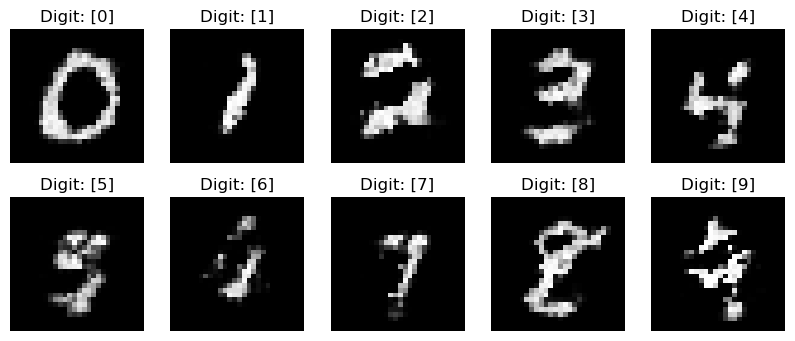

It:400 Disc loss:[0.3960522 0.7890625] acc:78.90625 gen loss:3.1835670471191406


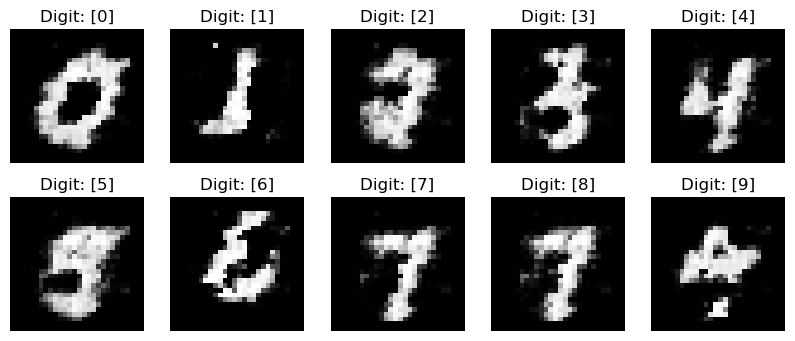

It:600 Disc loss:[0.52523785 0.53125   ] acc:53.125 gen loss:2.190459966659546


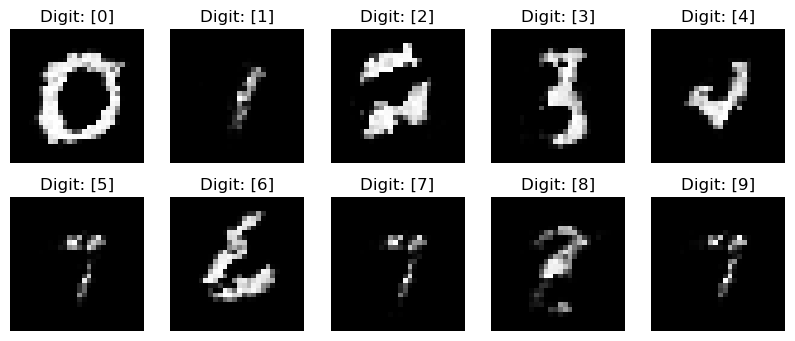

It:800 Disc loss:[0.39939643 0.96875   ] acc:96.875 gen loss:3.1067638397216797


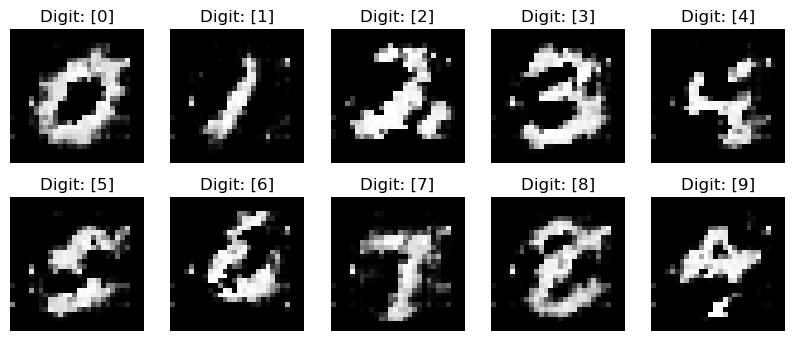

It:1000 Disc loss:[0.13614274 1.        ] acc:100.0 gen loss:0.29672300815582275


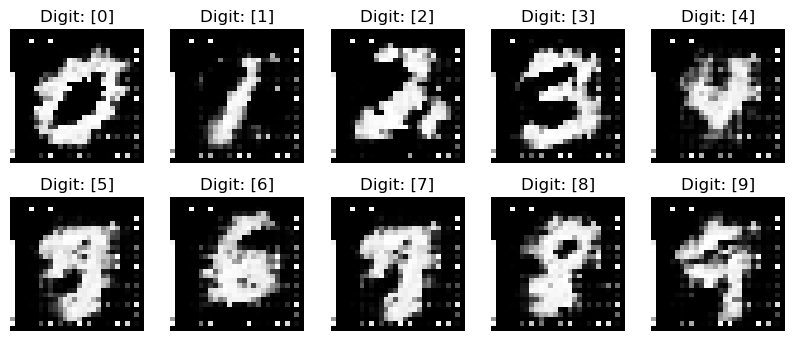

It:1200 Disc loss:[0.33066765 0.8515625 ] acc:85.15625 gen loss:2.019744396209717


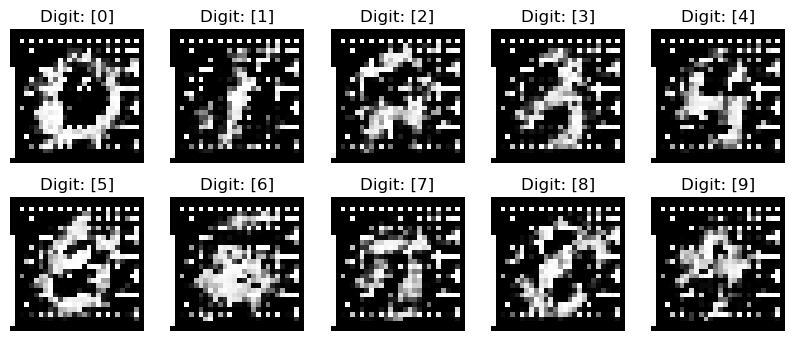

It:1400 Disc loss:[0.41762087 0.65625   ] acc:65.625 gen loss:3.384650945663452


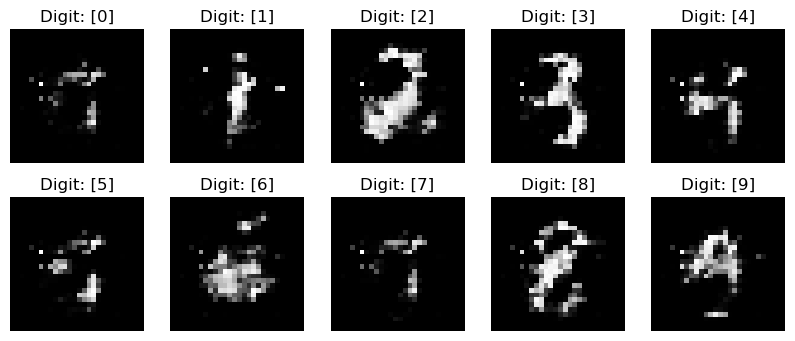

It:1600 Disc loss:[0.38995868 0.8828125 ] acc:88.28125 gen loss:2.539137363433838


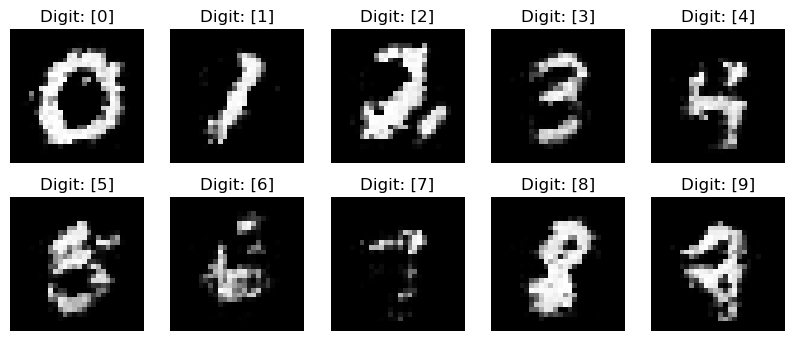

It:1800 Disc loss:[0.29990716 1.        ] acc:100.0 gen loss:3.1833584308624268


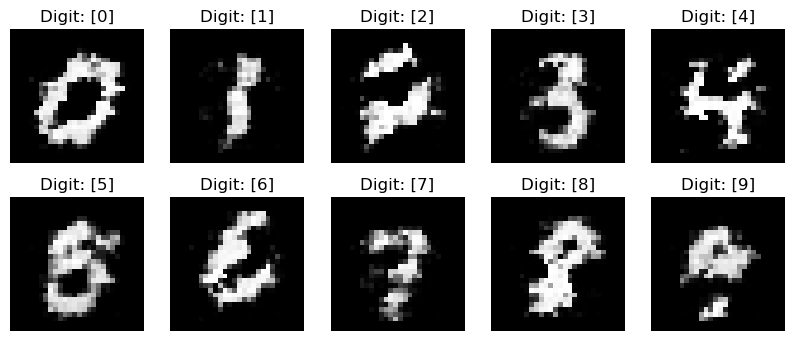

It:2000 Disc loss:[0.36108433 0.9453125 ] acc:94.53125 gen loss:3.3963284492492676


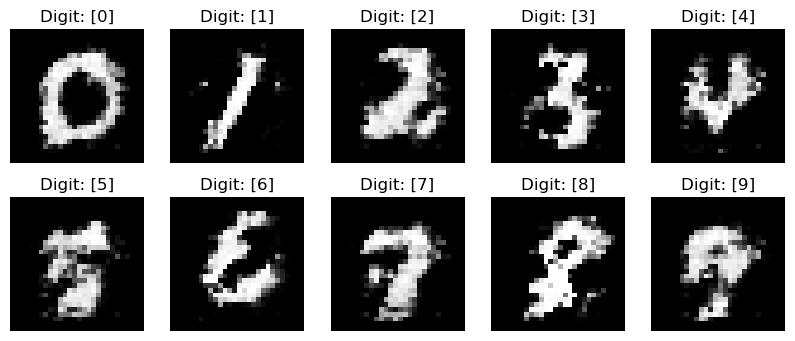

It:2200 Disc loss:[0.42288107 0.7109375 ] acc:71.09375 gen loss:3.1381771564483643


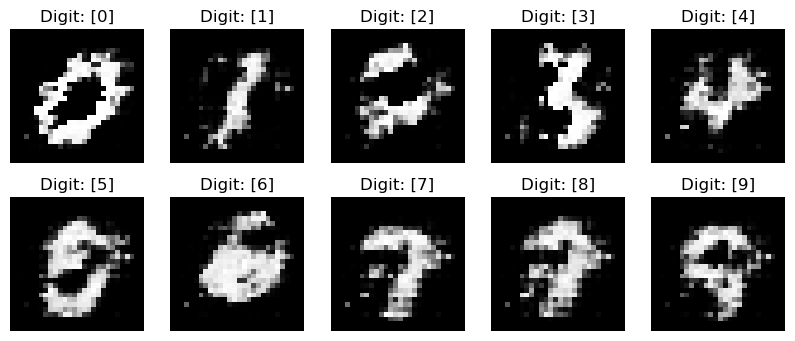

It:2400 Disc loss:[0.45306817 0.71875   ] acc:71.875 gen loss:3.4730334281921387


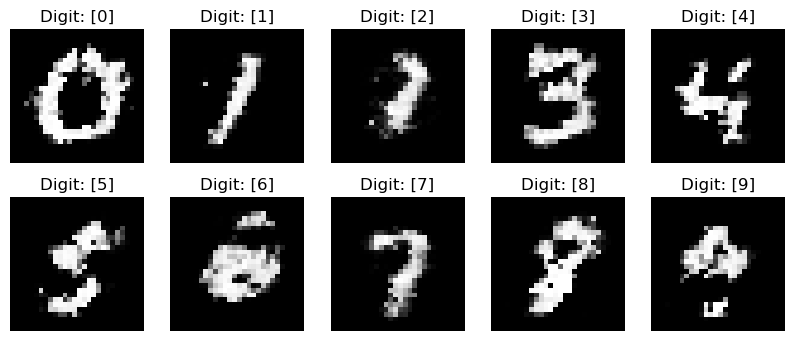

It:2600 Disc loss:[0.33041059 0.96875   ] acc:96.875 gen loss:3.0836262702941895


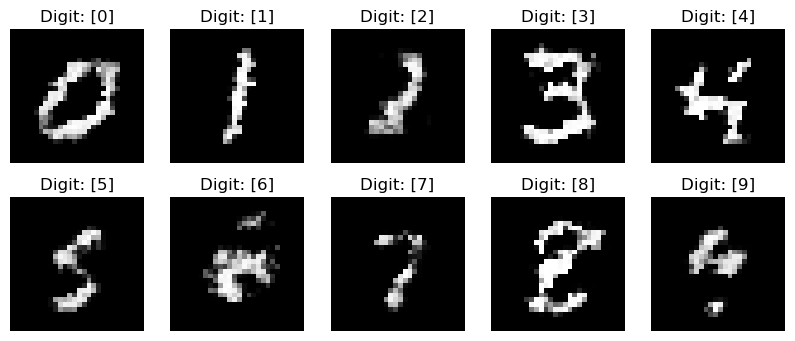

It:2800 Disc loss:[0.44135013 0.7109375 ] acc:71.09375 gen loss:2.6480090618133545


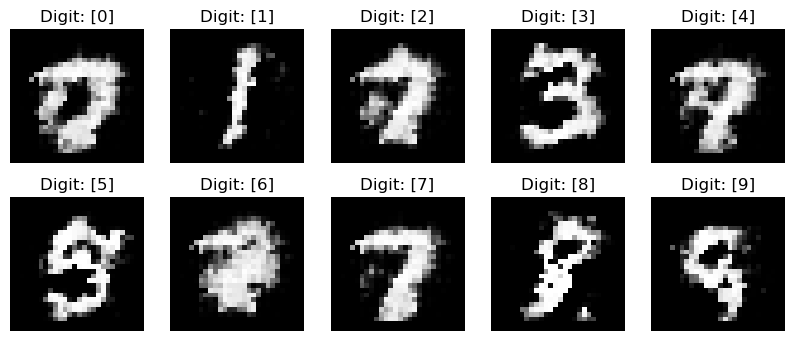

It:3000 Disc loss:[0.530885 0.5     ] acc:50.0 gen loss:2.4603238105773926


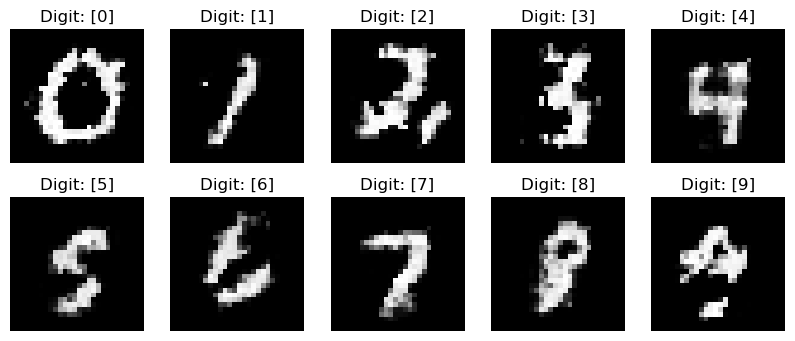

It:3200 Disc loss:[0.31111491 0.9921875 ] acc:99.21875 gen loss:2.9864368438720703


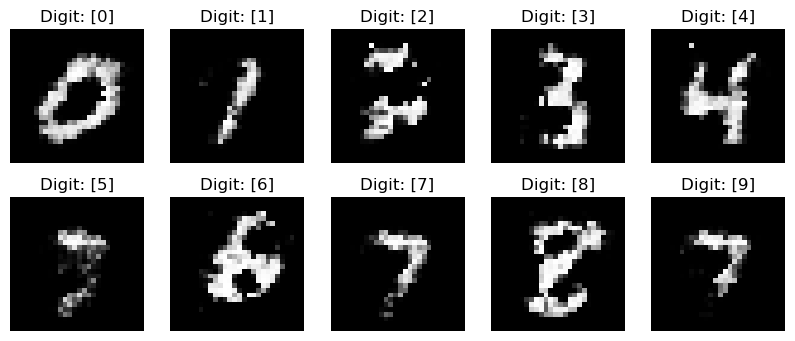

It:3400 Disc loss:[0.48120202 0.5234375 ] acc:52.34375 gen loss:2.911484479904175


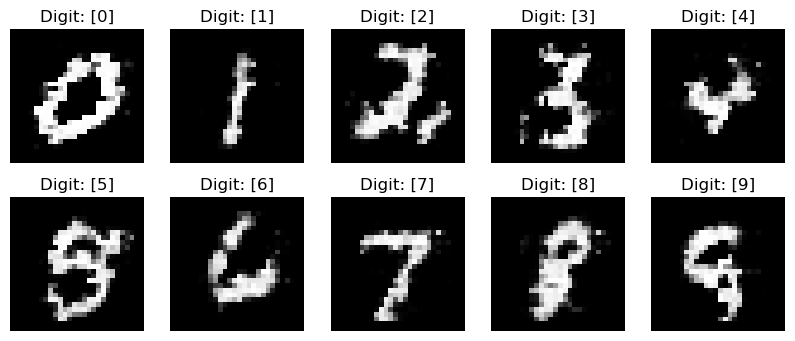

It:3600 Disc loss:[0.5390733 0.5078125] acc:50.78125 gen loss:2.8821983337402344


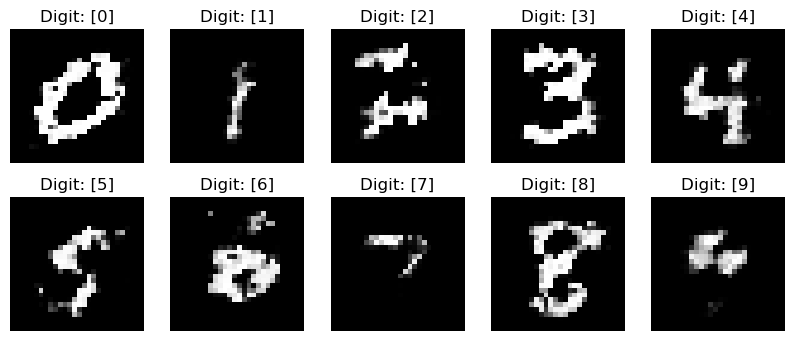

It:3800 Disc loss:[0.36510099 0.953125  ] acc:95.3125 gen loss:2.7285516262054443


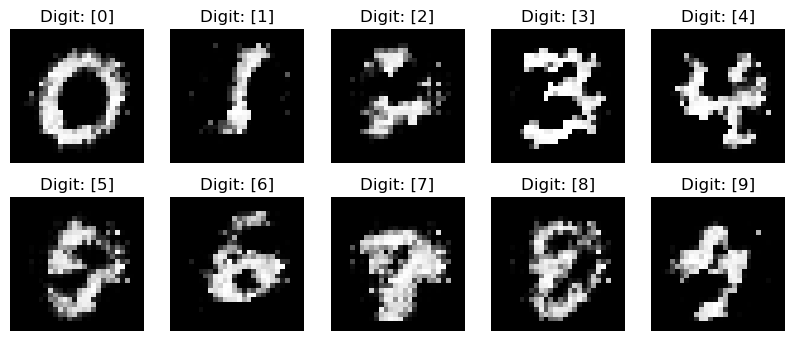

It:4000 Disc loss:[0.37612727 0.953125  ] acc:95.3125 gen loss:2.5483152866363525


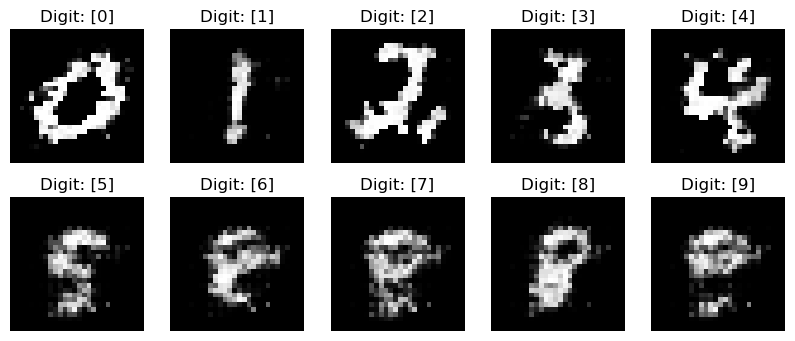

It:4200 Disc loss:[0.40098092 0.8359375 ] acc:83.59375 gen loss:2.5790703296661377


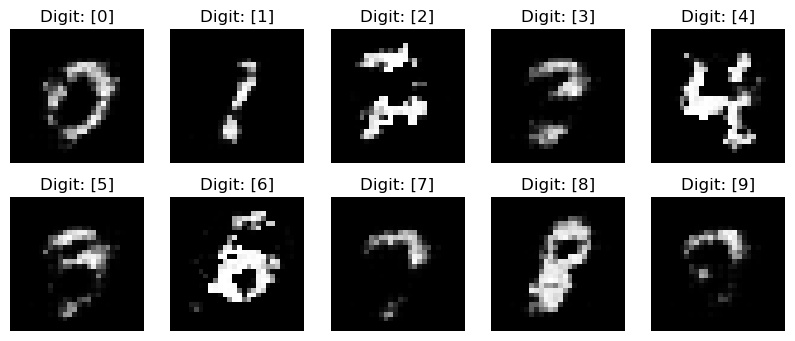

It:4400 Disc loss:[0.34060824 0.9921875 ] acc:99.21875 gen loss:3.509490728378296


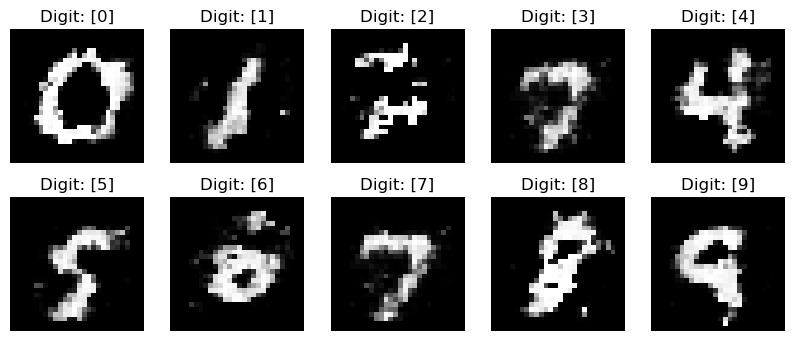

It:4600 Disc loss:[0.39561921 0.875     ] acc:87.5 gen loss:3.36221981048584


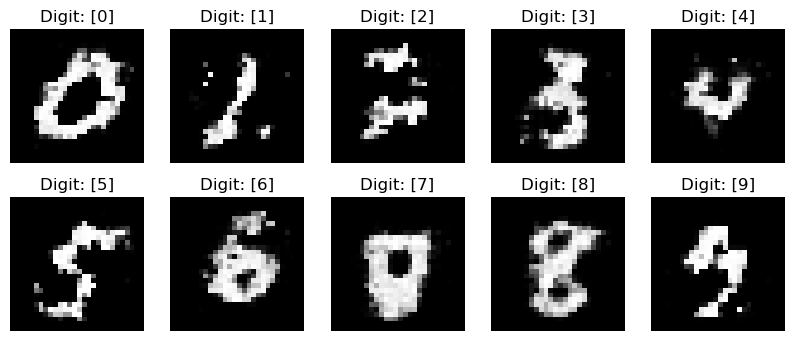

It:4800 Disc loss:[0.50736549 0.515625  ] acc:51.5625 gen loss:2.660959482192993


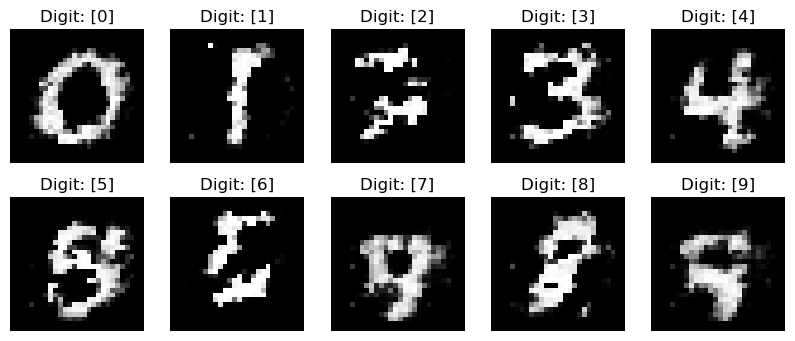

It:5000 Disc loss:[0.34161498 0.9609375 ] acc:96.09375 gen loss:2.6132688522338867


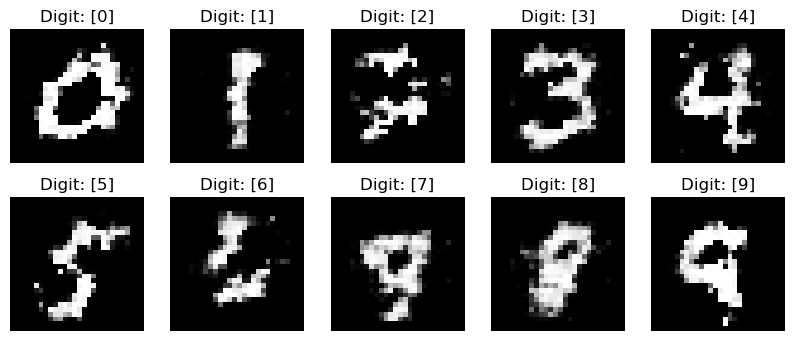

It:5200 Disc loss:[0.39799552 0.7578125 ] acc:75.78125 gen loss:2.688192367553711


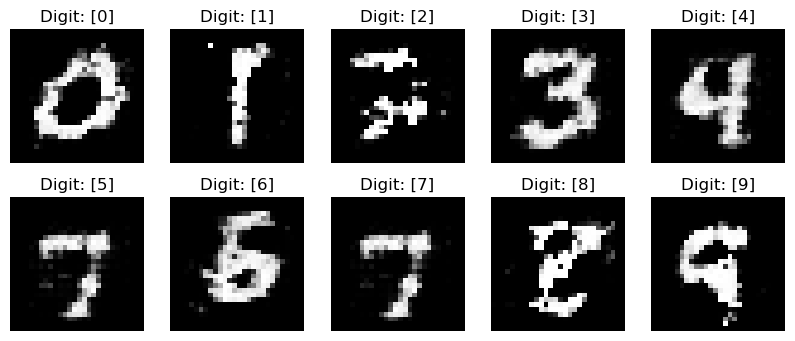

It:5400 Disc loss:[0.42644001 0.6640625 ] acc:66.40625 gen loss:2.4001588821411133


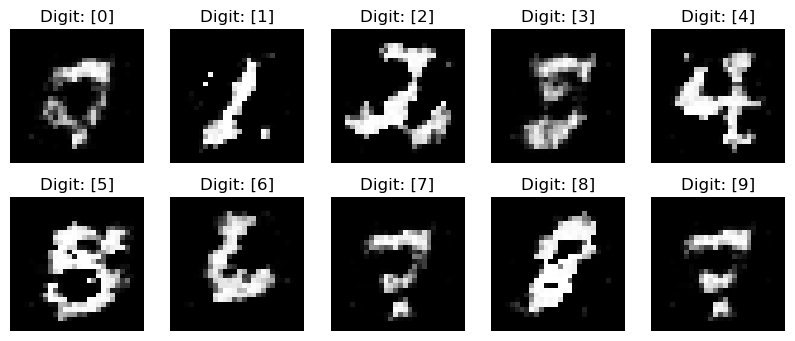

It:5600 Disc loss:[0.33087987 1.        ] acc:100.0 gen loss:2.2754502296447754


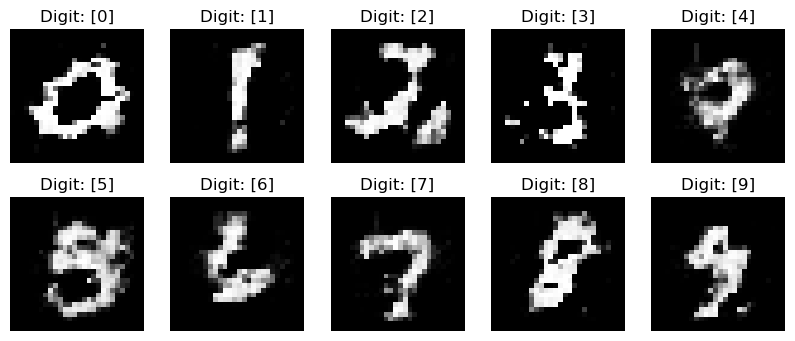

It:5800 Disc loss:[0.38077518 0.9140625 ] acc:91.40625 gen loss:2.316584587097168


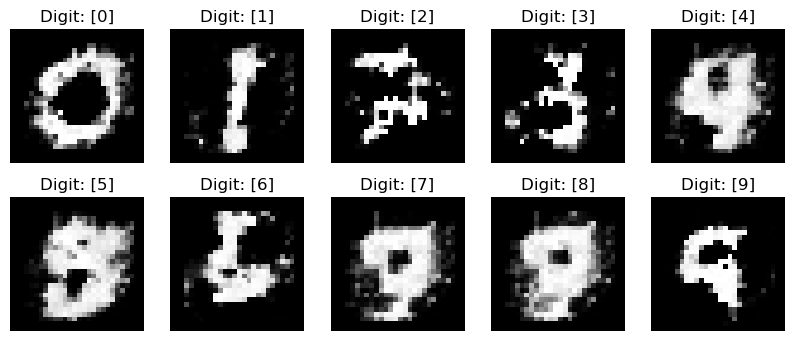

It:6000 Disc loss:[0.35811146 0.9921875 ] acc:99.21875 gen loss:2.411309242248535


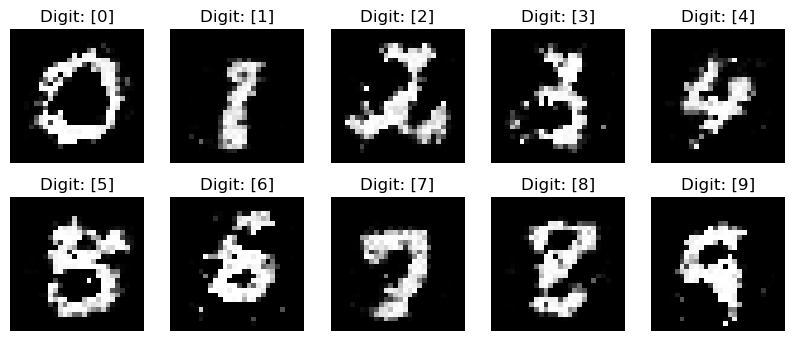

It:6200 Disc loss:[0.54504654 0.515625  ] acc:51.5625 gen loss:2.6729373931884766


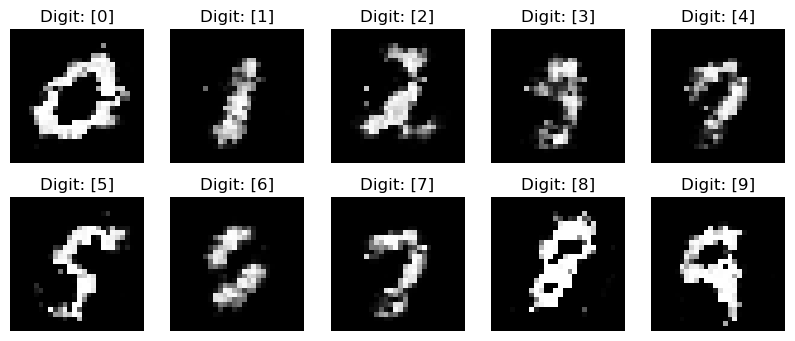

It:6400 Disc loss:[0.32605635 0.96875   ] acc:96.875 gen loss:2.874948501586914


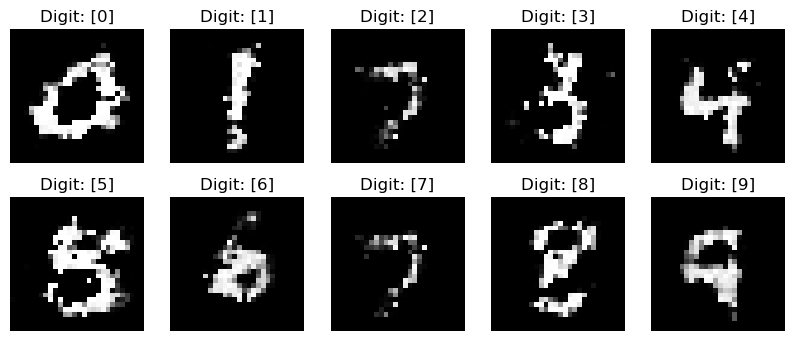

It:6600 Disc loss:[0.31519903 1.        ] acc:100.0 gen loss:2.9205188751220703


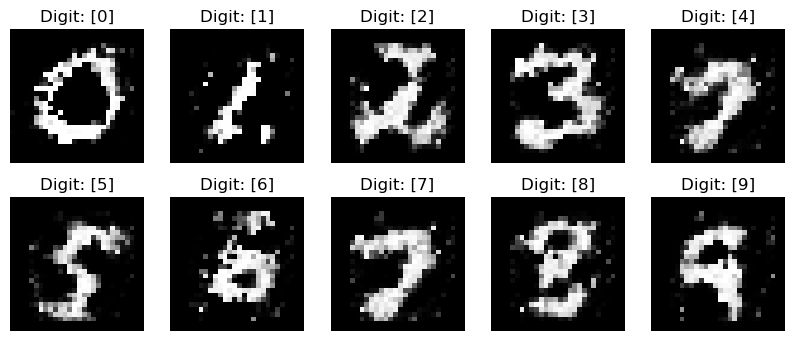

It:6800 Disc loss:[0.3497676 0.9765625] acc:97.65625 gen loss:3.282353401184082


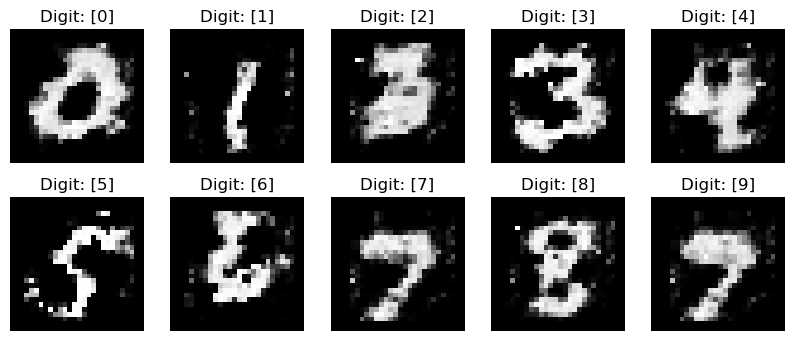

It:7000 Disc loss:[0.3277918 0.953125 ] acc:95.3125 gen loss:2.6760823726654053


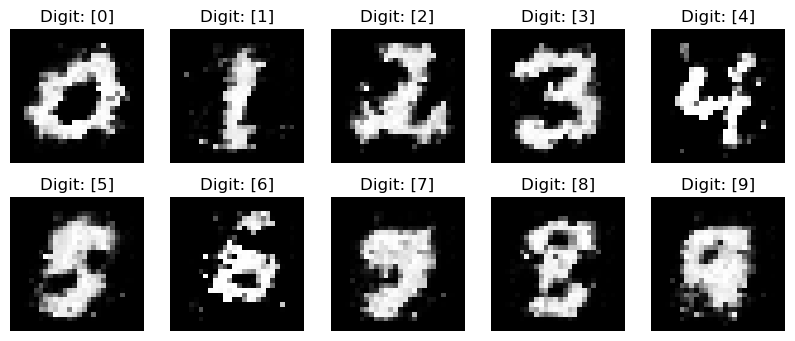

It:7200 Disc loss:[0.41441217 0.9609375 ] acc:96.09375 gen loss:2.226175308227539


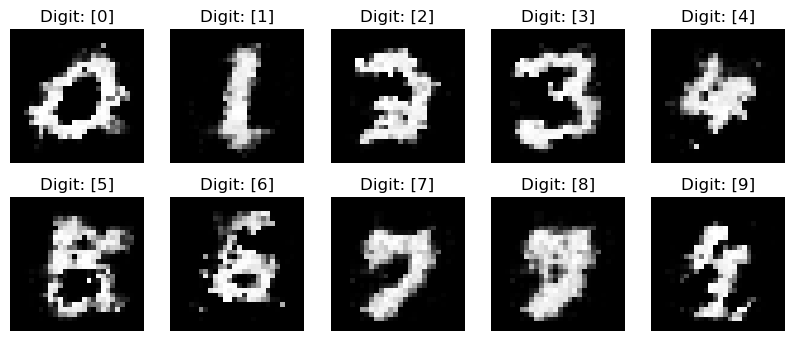

It:7400 Disc loss:[0.56850957 0.5       ] acc:50.0 gen loss:2.603912353515625


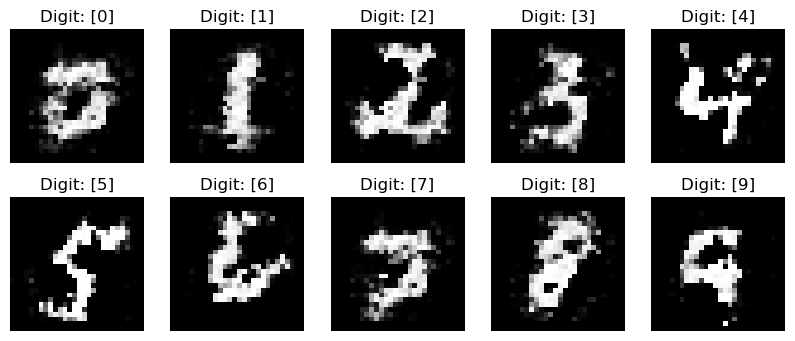

It:7600 Disc loss:[0.52831346 0.5546875 ] acc:55.46875 gen loss:2.0859453678131104


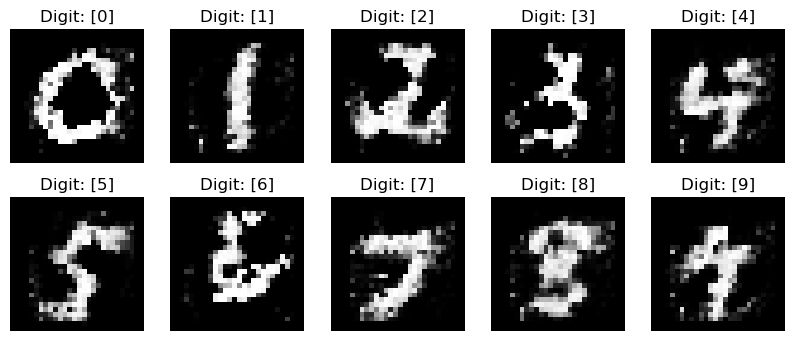

It:7800 Disc loss:[0.36773732 0.796875  ] acc:79.6875 gen loss:2.865304946899414


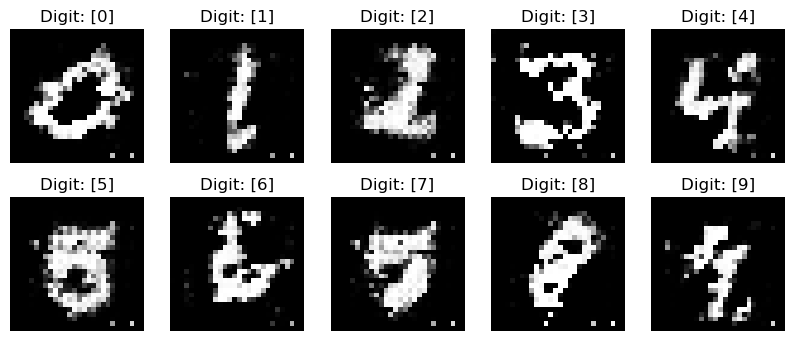

It:8000 Disc loss:[0.42820438 0.6328125 ] acc:63.28125 gen loss:2.172903060913086


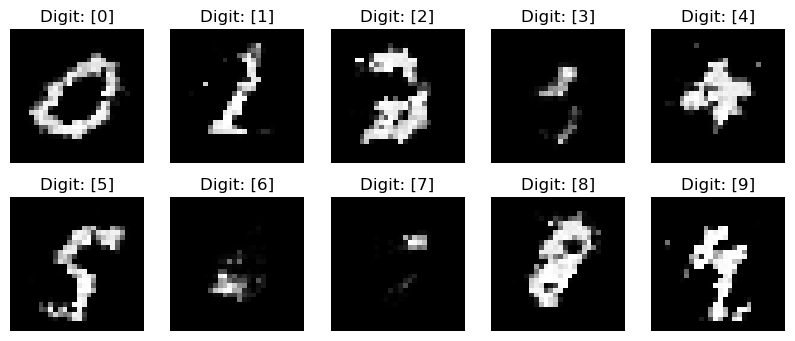

It:8200 Disc loss:[0.37000029 0.9921875 ] acc:99.21875 gen loss:2.6212408542633057


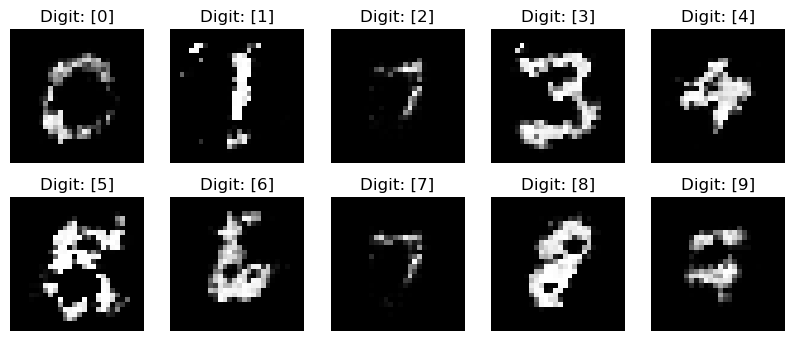

It:8400 Disc loss:[0.49140926 0.5703125 ] acc:57.03125 gen loss:2.755683422088623


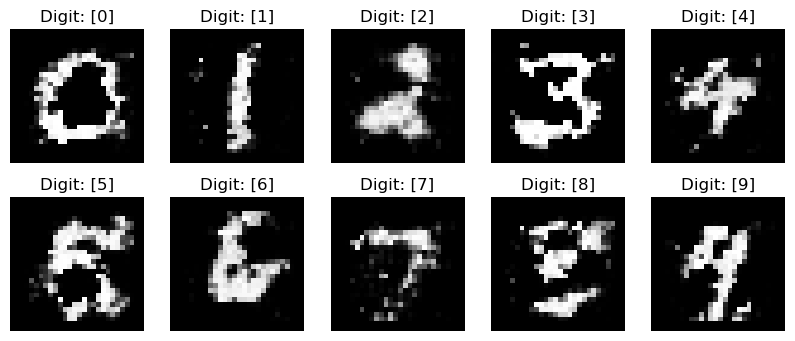

It:8600 Disc loss:[0.36237247 0.984375  ] acc:98.4375 gen loss:3.005223035812378


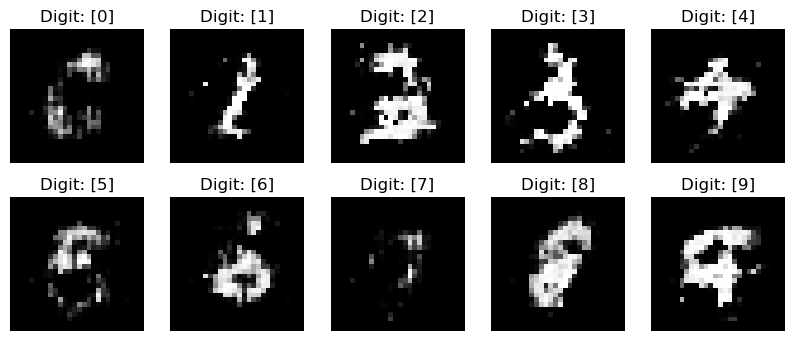

It:8800 Disc loss:[0.35856486 0.9765625 ] acc:97.65625 gen loss:2.2927122116088867


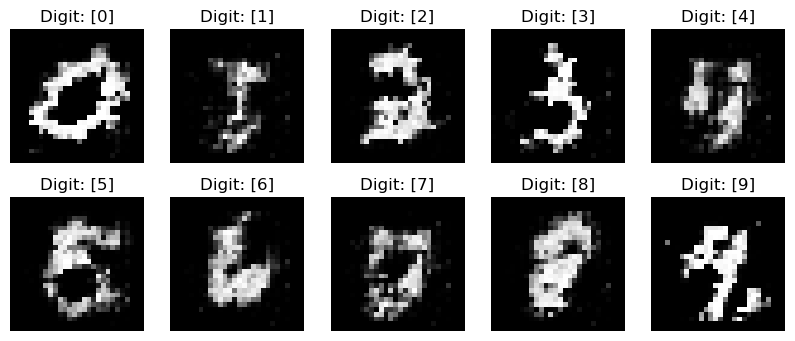

It:9000 Disc loss:[0.41663577 0.7421875 ] acc:74.21875 gen loss:3.067049026489258


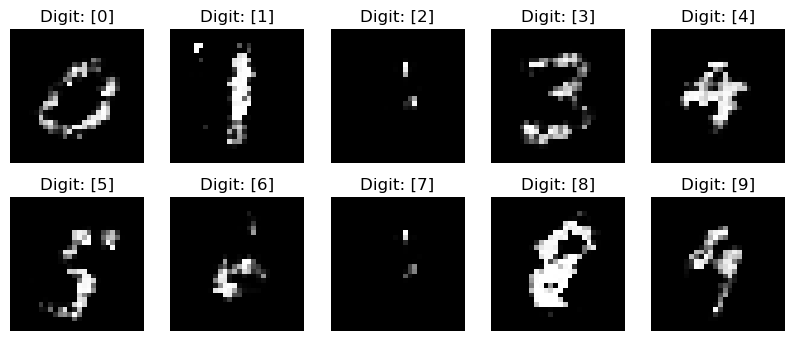

It:9200 Disc loss:[0.5034918 0.5078125] acc:50.78125 gen loss:2.795247793197632


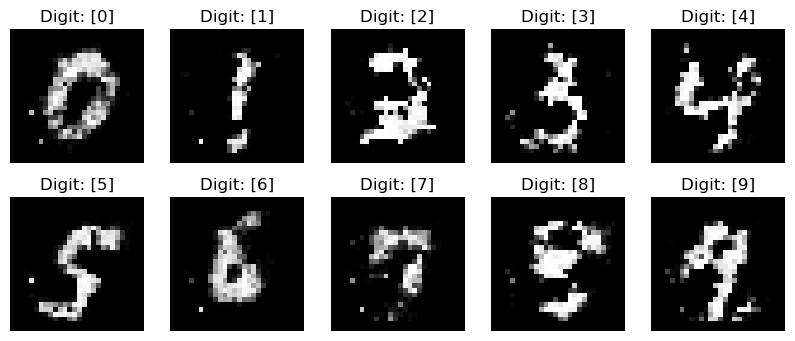

It:9400 Disc loss:[0.46749652 0.5703125 ] acc:57.03125 gen loss:2.754406452178955


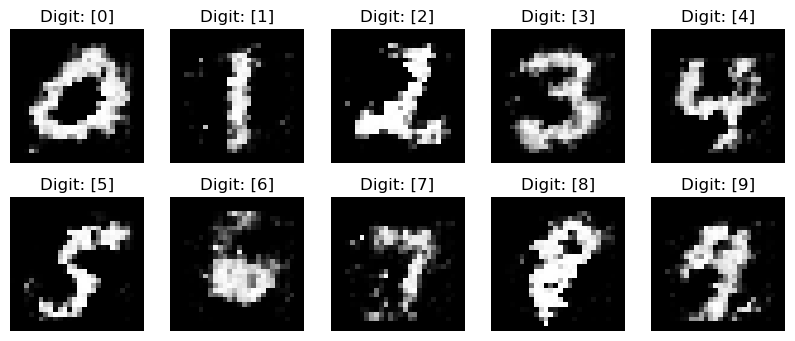

It:9600 Disc loss:[0.42113751 0.65625   ] acc:65.625 gen loss:2.792663097381592


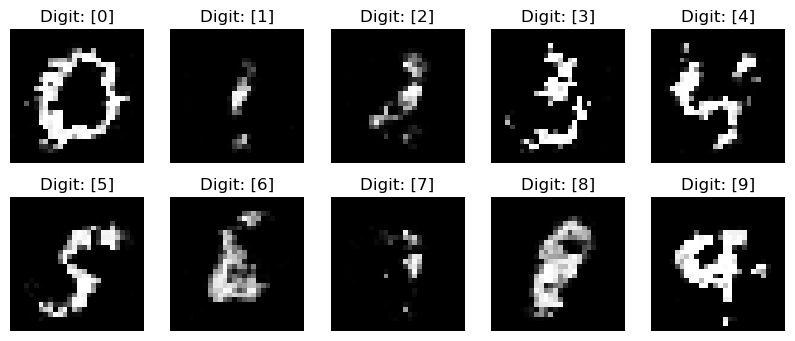

It:9800 Disc loss:[0.50610947 0.515625  ] acc:51.5625 gen loss:2.5275461673736572


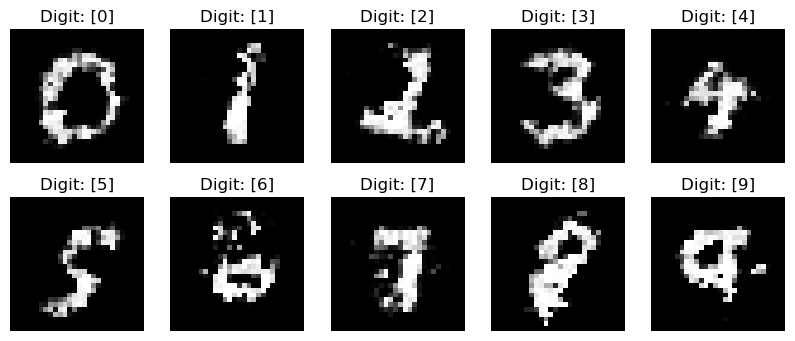

It:10000 Disc loss:[0.42345063 0.75      ] acc:75.0 gen loss:2.809619903564453


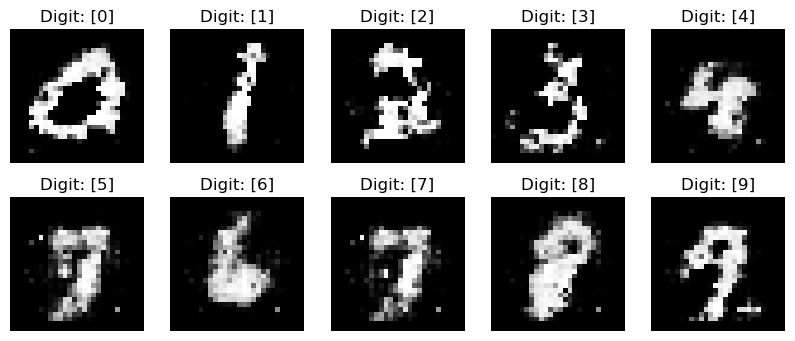

In [27]:
ITERATIONS = 10000
BATCH_SIZE = 64
SAMPLE_INTERVAL = 200

tf.keras.utils.disable_interactive_logging()
train(ITERATIONS, BATCH_SIZE, SAMPLE_INTERVAL)

In [19]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


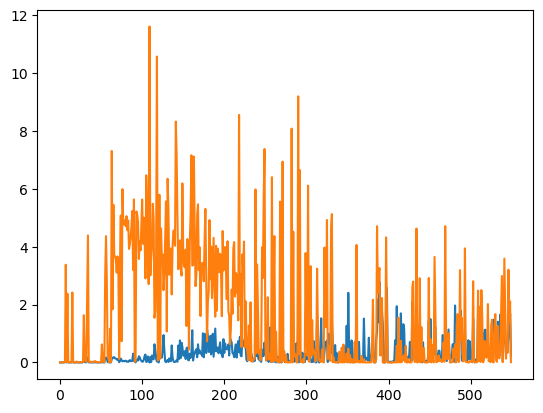

In [22]:
plt.plot(losses)